# Binary Classification Model for BNP Paribas Cardif Claims Management Using Scikit-Learn Take 2
### David Lowe
### August 10, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The BNP Paribas Cardif Claims Management dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: As a global specialist in personal insurance, BNP Paribas Cardif sponsored a Kaggle competition to help them identify the categories of claims. In a world shaped by the emergence of new practices and behaviors generated by the digital economy, BNP Paribas Cardif would like to streamline its claims management practice. In this Kaggle challenge, the company challenged the participants to predict the category of a claim based on features available early in the process. Better predictions can help BNP Paribas Cardif accelerate its claims process and therefore provide a better service to its customers.

In iteration Take1, we constructed and tuned several machine learning models using the Scikit-learn library. Furthermore, we applied the best-performing machine learning model to Kaggle's test dataset and submitted a list of predictions for evaluation.

In this Take2 iteration, we will construct and tune an XGBoost model. Furthermore, we will apply the XGBoost model to Kaggle's test dataset and submit a list of predictions for evaluation.

ANALYSIS: From iteration Take1, the baseline performance of the machine learning algorithms achieved an average log loss of 0.6422. Two algorithms (Logistic Regression and Random Forest) achieved the top log loss metrics after the first round of modeling. After a series of tuning trials, Random Forest turned in a better overall result. Random Forest achieved a log loss metric of 0.4722. When configured with the optimized parameters, the Extra Trees model processed the validation dataset with a log loss of 0.4706, which was consistent with the model training phase. When we applied the Random Forest model to Kaggle's test dataset, we obtained a log loss score of 0.4635.

From this Take2 iteration, the baseline performance of the XGBoost model achieved a log loss of 0.4706. After a series of tuning trials, the XGBoost model reached a log loss metric of 0.4650. When configured with the optimized parameters, the XGBoost model processed the validation dataset with a log loss of 0.4674, which was consistent with the model training phase. When we applied the XGBoost model to Kaggle's test dataset, we obtained a log loss score of 0.4634.

CONCLUSION: For this iteration, the XGBoost model achieved the best overall results using the training and test datasets. For this dataset, we should consider further modeling with the XGBoost algorithm.

Dataset Used: BNP Paribas Cardif Claims Management Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/overview

One potential source of performance benchmark: https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Prepare and Clean Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
!pip install python-dotenv PyMySQL

     |████████████████████████████████| 51kB 4.8MB/s 


In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Aug  4 23:39:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import smtplib
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
# test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'neg_log_loss'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-bnp-paribas-cardif-claims-management/train.csv'
Xy_original = pd.read_csv(dataset_path, sep=',', index_col=False)

# Take a peek at the dataframe after import
Xy_original.head(10)

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,...,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,6.085711,2.866830,11.636387,1.355013,8.571429,3.670350,0.106720,0.148883,18.869283,7.730923,XDX,-1.716131e-08,C,0.139412,1.720818,3.393503,0.590122,8.880867,C,A,1.083033,1.010829,7.270147,8.375452,11.326592,0.454546,0,...,0.442252,5.814018,3.517720,0.462019,7.436824,5.454545,8.877414,1.191337,19.470199,8.389237,2.757375,4.374296,1.574039,0.007294,12.579184,E,2.382692,3.930922,B,0.433213,O,NaN,15.634907,2.857144,1.951220,6.592012,5.909091,-6.297423e-07,1.059603,0.803572,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,1.312910,NaN,6.507647,NaN,11.636386,NaN,NaN,NaN,NaN,NaN,NaN,6.763110,GUV,NaN,C,3.056144,NaN,NaN,NaN,NaN,C,A,NaN,NaN,3.615077,NaN,14.579479,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.303967,NaN,NaN,NaN,NaN,NaN,NaN,1.505335,NaN,B,1.825361,4.247858,A,NaN,U,G,10.308044,NaN,NaN,10.595357,NaN,NaN,NaN,NaN,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,6.384670,2.505589,9.603542,1.984127,5.882353,3.170847,0.244541,0.144258,17.952332,5.245035,FQ,-2.785053e-07,E,0.113997,2.244897,5.306122,0.836005,7.499999,NaN,A,1.454082,1.734693,4.043864,7.959184,12.730517,0.259740,0,...,0.271480,5.156559,4.214944,0.309657,5.663265,5.974026,11.588858,0.841837,15.491329,5.879353,3.292788,5.924457,1.668401,0.008275,11.670572,C,1.375753,1.184211,B,3.367348,S,NaN,11.205561,12.941177,3.129253,3.478911,6.233767,-2.792745e-07,2.138728,2.238806,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,9.646653,3.903302,14.094723,1.945044,5.517242,3.610789,1.224114,0.231630,18.376407,7.517125,ACUE,-4.805344e-07,D,0.148843,1.308269,2.303640,8.926662,8.874521,C,B,1.587644,1.666667,8.703550,8.898468,11.302795,0.433735,0,...,0.763925,5.498902,3.423944,0.832518,7.375480,6.746988,6.942002,1.334611,18.256352,8.507281,2.503055,4.872157,2.573664,0.113967,12.554274,B,2.230754,1.990131,B,2.643678,J,NaN,13.777666,10.574713,1.511063,4.949609,7.180722,5.655086e-01,1.166281,1.956521,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.050328,NaN,6.320087,NaN,10.991098,NaN,NaN,NaN,NaN,NaN,NaN,6.414567,HIT,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,6.083151,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,A,NaN,T,G,14.097099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN
5,9,0,NaN,NaN,C,NaN,8.856791,NaN,NaN,0.359993,NaN,1.050328,NaN,6.216077,NaN,11.916255,NaN,NaN,NaN,NaN,NaN,NaN,7.351426,AYX,NaN,A,0.218458,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,7.496613,NaN,15.497964,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.970103,NaN,NaN,NaN,NaN,NaN,NaN,0.193530,NaN,C,1.763765,2.442616,A,NaN,D,X,15.750502,NaN,NaN,8.851677,NaN,NaN,NaN,NaN,NaN,NaN,0.049861,X,NaN,NaN,1.536222,0,NaN,NaN
6,12,0,0.899806,7.312995,C,3.494148,9.946200,1.926070,1.770427,0.066251,5.011287,2.341356,16.274510,7.711174,5.915588,12.148604,1.968303,6.601941,2.873974,0.484133,0.443661,17.226675,6.661479,NFD,7.813019e-07,E,0.180765,1.070040,1.566147,4.393842,7.928015,G,A,1.619651,2.003892,3.964911,8.735408,13.967877,0.549451,0,...,0.766422,5.875069,5.841754,0.863301,6.643969,6.043957,6.079678,1.301881,19.036496,7.492828,2.511898,6.310835,4.697276,0.047703,11.075756,B,2.254819,5.180922,B,2.568094,I,NaN,9.010082,8.543690,1.349693,12.168719,6.593406,1.532727e+00,0.846716,2.232558,3.476299,

In [11]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114321 entries, 0 to 114320
Data columns (total 133 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ID      int64  
 1   target  int64  
 2   v1      float64
 3   v2      float64
 4   v3      object 
 5   v4      float64
 6   v5      float64
 7   v6      float64
 8   v7      float64
 9   v8      float64
 10  v9      float64
 11  v10     float64
 12  v11     float64
 13  v12     float64
 14  v13     float64
 15  v14     float64
 16  v15     float64
 17  v16     float64
 18  v17     float64
 19  v18     float64
 20  v19     float64
 21  v20     float64
 22  v21     float64
 23  v22     object 
 24  v23     float64
 25  v24     object 
 26  v25     float64
 27  v26     float64
 28  v27     float64
 29  v28     float64
 30  v29     float64
 31  v30     object 
 32  v31     object 
 33  v32     float64
 34  v33     float64
 35  v34     float64
 36  v35     float64
 37  v36     float64
 38  v37     float64
 39  v38     int64  
 40  v

### 1.d) Splitting Data into Training/Validation/Test Sets

In [12]:
# Drop the ID or index column not used for modeling
Xy_original.drop(columns=['ID'], inplace=True)

# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [13]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (114321, 132) X_original.shape: (114321, 131) y_original.shape: (114321,)


In [14]:
# Split the data further into smaller datasets
X_train_df, X_validation_df, y_train_df, y_validation_df = train_test_split(X_original, y_original, test_size=val_set_size, stratify=y_original, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_validation_df.shape: {} y_validation_df.shape: {}".format(X_validation_df.shape, y_validation_df.shape))

X_train_df.shape: (85740, 131) y_train_df.shape: (85740,)
X_validation_df.shape: (28581, 131) y_validation_df.shape: (28581,)


### 1.e) Set up the parameters for data visualization

In [15]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [16]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [17]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [18]:
X_train_df.head(10)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,...,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
72729,2.501891e-07,9.825911,C,5.231909,9.769272,2.308403,2.197599,1.450759,9.632652,1.312911,15.422680,6.601625,3.598723,13.024279,2.497225,2.898550,6.876546,0.674253,0.194467,18.312501,8.169976,AAKG,5.853703e-02,E,2.255880,1.760541,2.991690,4.629035,8.319483,NaN,A,1.634349,1.274237,5.415195,7.460757,13.635682,-9.497579e-07,0,0.249480,11.459374,...,0.633039,7.766967,3.178398,0.679330,6.361958,8.739497,6.178443,1.354263,15.932914,7.800456,4.181482,5.104609,2.465886,1.233495,16.355611,A,2.662885,6.601851,A,2.216066,F,L,12.940710,11.594203,2.308547,12.616976,8.739495,3.090737e-07,0.272537,2.177123,8.816327,1.414677,1.404986,L,1.063325,5.470914,2.526560,0,1.159664,-3.711267e-07
63077,2.038942e+00,7.202753,C,4.510721,9.057249,2.689199,2.138133,2.422964,10.123457,1.575492,13.146854,6.746417,6.579467,12.512039,4.930173,7.029702,4.467047,1.364054,0.288734,17.929830,7.435390,FIJ,-9.620531e-07,C,3.867568,1.535636,2.520205,5.817832,7.979427,C,A,3.614989,2.968406,7.660190,6.847906,14.402246,1.030928e+00,0,1.143489,8.173794,...,0.622682,6.103175,4.591421,0.745266,5.356355,6.804124,9.282920,1.872399,2.860103,5.362821,2.810917,6.157816,5.189820,1.742531,12.005420,A,1.739222,4.779135,A,3.526819,R,AC,15.446051,7.920793,1.823204,10.705738,7.835051,1.616250e-01,2.217616,3.710022,7.932098,2.586637,1.112611,J,2.059444,4.808046,2.065386,0,2.776633,1.485149e+00
18397,4.811450e-01,8.154912,C,5.131863,8.682855,2.431729,1.657998,8.625817,5.284974,1.859956,14.748686,6.164424,6.800576,13.045161,2.936474,5.223881,6.737957,1.271468,0.450685,17.534705,7.711387,GEJ,-7.076600e-07,E,8.440862,1.752276,2.204161,6.574728,7.795839,NaN,C,1.989597,1.742522,5.562501,7.360208,14.512954,3.137250e-01,2,0.481081,11.777006,...,0.809566,8.482329,5.557384,0.898165,5.767230,11.215686,5.821114,1.406589,1.423013,7.345575,3.306173,7.714154,5.471374,6.022547,13.166470,E,1.379097,4.461029,B,2.184656,R,NaN,13.624344,8.358208,2.385321,10.184905,11.529412,4.416440e-01,1.389660,2.560646,4.378238,2.199685,3.197708,CE,2.373403,4.608258,1.932607,0,2.101960,5.970149e-01
107232,5.698150e-01,4.747883,C,2.660194,8.451288,1.581109,2.289527,0.501510,8.118081,1.312911,14.894738,6.770576,3.947815,12.357702,2.384737,5.648855,1.464257,0.510284,0.275878,16.008471,7.410128,VDR,-4.409486e-07,E,0.664245,1.599931,2.813141,4.162924,6.457906,NaN,A,1.694045,2.689939,5.931344,7.453798,15.753253,2.690585e-01,0,0.089902,10.643225,...,0.447102,3.313790,4.697621,0.552503,4.876797,7.354260,8.355626,0.734085,16.481995,4.034774,2.772894,7.049473,3.032814,0.262429,6.654770,E,1.697967,2.196174,A,3.264887,I,AJ,13.425922,8.091603,2.607313,8.172146,7.623319,1.194743e+01,0.249308,3.911175,5.313653,6.929852,0.160894,BM,1.784636,2.252311,1.420580,0,2.349776,4.580151e-01
10477,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.291028,NaN,6.178489,NaN,11.636387,NaN,NaN,NaN,NaN,NaN,NaN,6.730570,AGDF,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,6.909907,NaN,NaN,NaN,0,NaN,9.073872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,B,NaN,F,NaN,15.172799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AZ,NaN,NaN,NaN,0,NaN,NaN
77299,4.009852e+00,2.623027,C,2.494071,8.225611,1.871922,1.931034,1.507072,13.868194,2.341358,13.828350,7.286157,5.631048,12.833736,4.773796,5.161290,1.116757,0.916673,0.267382,16.469956,7.434235,AFOZ,8.608686e-07,C,1.809336,1.408868,2.334975,4.338252,8.384236,G,A,3.576354,3.665024,7.041676,8.926108,15.268928,2.244899e+00,0,0.250230,9.922581,...,0.740184,2.892306,3.840034,0.910203,5.911330,5.714286,7.377550,0.668309,4.009252,2.745712,2.207123,4.302559,3.747958,0.863089,5.176645,B,1.888868,3.102562,B,4.492610,N,NaN,14.241164,8.172043,1.316098,8.709426,7.959183,8.965103e

#### 2.a.ii) Dimensions and attribute types

In [19]:
X_train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85740 entries, 72729 to 73581
Data columns (total 131 columns):
 #   Column  Dtype  
---  ------  -----  
 0   v1      float64
 1   v2      float64
 2   v3      object 
 3   v4      float64
 4   v5      float64
 5   v6      float64
 6   v7      float64
 7   v8      float64
 8   v9      float64
 9   v10     float64
 10  v11     float64
 11  v12     float64
 12  v13     float64
 13  v14     float64
 14  v15     float64
 15  v16     float64
 16  v17     float64
 17  v18     float64
 18  v19     float64
 19  v20     float64
 20  v21     float64
 21  v22     object 
 22  v23     float64
 23  v24     object 
 24  v25     float64
 25  v26     float64
 26  v27     float64
 27  v28     float64
 28  v29     float64
 29  v30     object 
 30  v31     object 
 31  v32     float64
 32  v33     float64
 33  v34     float64
 34  v35     float64
 35  v36     float64
 36  v37     float64
 37  v38     int64  
 38  v39     float64
 39  v40     float64
 40 

#### 2.a.iii) Statistical summary of the attributes

In [20]:
X_train_df.describe()

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v23,v25,v26,v27,v28,v29,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,...,v86,v87,v88,v89,v90,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v108,v109,v111,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v126,v127,v128,v129,v130,v131
count,4.850000e+04,4.852600e+04,4.852600e+04,4.940800e+04,4.850000e+04,4.850000e+04,4.941200e+04,4.848700e+04,8.567900e+04,4.849600e+04,8.567700e+04,4.850000e+04,8.573700e+04,4.849600e+04,4.845900e+04,4.852600e+04,4.850000e+04,4.849400e+04,48495.000000,85276.000000,4.787000e+04,49412.000000,4.850000e+04,4.850000e+04,4.850000e+04,4.850000e+04,4.850000e+04,4.850000e+04,8.565900e+04,4.850000e+04,4.940800e+04,4.849400e+04,85740.000000,4.849600e+04,8.565900e+04,4.850000e+04,4.850000e+04,4.849600e+04,4.852600e+04,4.850000e+04,...,4.850000e+04,49377.000000,4.850000e+04,49412.000000,4.849700e+04,4.849400e+04,48500.000000,4.850000e+04,4.849400e+04,4.850000e+04,4.849400e+04,4.938700e+04,4.850000e+04,4.849600e+04,4.852600e+04,4.739000e+04,4.850000e+04,4.850000e+04,49381.000000,4.852600e+04,4.940800e+04,4.940800e+04,4.850000e+04,8.571700e+04,4.845900e+04,4.849600e+04,4.940800e+04,4.849400e+04,4.786600e+04,4.849600e+04,4.849500e+04,4.848700e+04,47868.000000,4.941200e+04,4.850000e+04,4.850000e+04,4.940800e+04,85740.000000,4.849400e+04,4.845900e+04
mean,1.629610e+00,7.455411e+00,4.145609e+00,8.735930e+00,2.438247e+00,2.482910e+00,1.497857e+00,9.035824e+00,1.883491e+00,1.544844e+01,6.880754e+00,3.799427e+00,1.209489e+01,2.081717e+00,4.927263e+00,3.830486e+00,8.412843e-01,2.220620e-01,17.775832,7.028918,1.082087e+00,1.694492,1.873865e+00,2.743278e+00,5.086353e+00,8.205276e+00,1.622916e+00,2.161664e+00,6.408833e+00,8.120201e+00,1.337884e+01,7.406509e-01,0.091766,1.241919e+00,1.046233e+01,7.182062e+00,1.292327e+01,2.214380e+00,1.079693e+01,9.134088e+00,...,1.220676e+00,10.171218,1.921455e+00,1.511418,9.659334e-01,5.825883e-01,5.477386,3.852340e+00,6.659410e-01,6.457582e+00,7.617956e+00,7.671520e+00,1.251250e+00,1.210080e+01,6.864618e+00,2.887360e+00,5.296495e+00,2.643858e+00,1.079285,1.179119e+01,2.149501e+00,4.163574e+00,3.367776e+00,1.357801e+01,1.055396e+01,2.288866e+00,8.289716e+00,8.359265e+00,3.154467e+00,1.292252e+00,2.737478e+00,6.823857e+00,3.542958,9.205091e-01,1.672165e+00,3.247758e+00,2.026497e+00,0.310753,1.925066e+00,1.738178e+00
std,1.080319e+00,2.948519e+00,1.143439e+00,2.041854e+00,5.929179e-01,5.837708e-01,2.787460e+00,1.926138e+00,1.392860e+00,7.804447e-01,9.240169e-01,1.178029e+00,1.438606e+00,7.282807e-01,1.786080e+00,1.911112e+00,6.132987e-01,1.599547e-01,1.140694,1.068978,3.984721e+00,2.948131,5.438005e-01,8.302390e-01,2.665787e+00,1.282406e+00,5.599326e-01,9.839740e-01,2.025587e+00,1.336062e+00,2.354133e+00,5.321136e-01,0.587903,2.377469e+00,3.171787e+00,1.001277e+00,1.001597e+00,6.390599e-01,2.104942e+00,2.058035e+00,...,4.617158e-01,2.995291,1.040984e+00,2.794830,1.769688e-01,2.423076e-01,1.637935,8.471171e-01,2.658230e-01,1.116609e+00,1.921227e+00,2.328016e+00,4.552936e-01,6.881316e+00,2.353001e+00,1.816062e+00,1.224865e+00,8.859762e-01,2.241853,2.945511e+00,9.132009e-01,3.699834e+00,1.487592e+00,2.612968e+00,1.895253e+00,6.610541e-01,3.612310e+00,1.999919e+00,4.229102e+00,7.358985e-01,1.355712e+00,1.789906e+00,2.595670,2.102663e+00,4.891719e-01,1.633572e+00,1.072913e+00,0.691401,1.260120e+00,1.131693e+00
min,-9.996497e-07,-8.757841e-07,-6.475929e-07,-5.287068e-07,-9.055091e-07,-9.291187e-07,-4.233768e-07,-9.828757e-07,-9.875317e-07,-1.358144e-07,5.143224e-07,-8.464889e-07,-9.738831e-07,-8.830427e-07,-9.977769e-07,-6.868651e-07,4.475470e-07,4.041601e-07,3.273921,0.106181,-9.999932e-07,0.041043,-9.346696e-07,-9.915986e-07,-6.960880e-07,-3.040753e-07,-9.559960e-07,-9.713108e-07,-6.707670e-07,-9.958327e-07,-4.906628e-07,-9.999498e-07,0.000000,-9.999742e-07,1.238996e-07,-7.272275e-07,-6.206144e-07,-9.724295e-07,-9.482212e-07,-9.202112e-07,...,-9.814310e-07,0.872396,-9.990082e-07,0.0223

#### 2.a.iv) Find Attributes with Missing Values

In [21]:
X_train_df.isnull().sum()

v1      37240
v2      37214
v3       2608
v4      37214
v5      36332
v6      37240
v7      37240
v8      36328
v9      37253
v10        61
v11     37244
v12        63
v13     37240
v14         3
v15     37244
v16     37281
v17     37214
v18     37240
v19     37246
v20     37245
v21       464
v22       374
v23     37870
v24         0
v25     36328
v26     37240
v27     37240
v28     37240
v29     37240
v30     44994
v31      2608
v32     37240
v33     37240
v34        81
v35     37240
v36     36332
v37     37246
v38         0
v39     37244
v40        81
v41     37240
v42     37240
v43     37244
v44     37214
v45     37240
v46     36328
v47         0
v48     37214
v49     37240
v50        63
v51     37872
v52         3
v53     37244
v54     36328
v55     37240
v56      5164
v57     37240
v58     37244
v59     37214
v60     37240
v61     37214
v62         0
v63     36328
v64     37214
v65     37245
v66         0
v67     37240
v68     37244
v69     37281
v70     36339
v71         0
v72   

In [22]:
print('Total number of NaN in the dataframe: ', X_train_df.isnull().sum().sum())

Total number of NaN in the dataframe:  3809526


#### 2.a.v) Summarize the levels of the class attribute

In [23]:
y_train_df.groupby(y_train_df).size()

target
0    20475
1    65265
Name: target, dtype: int64

### 2.b) Data Visualization

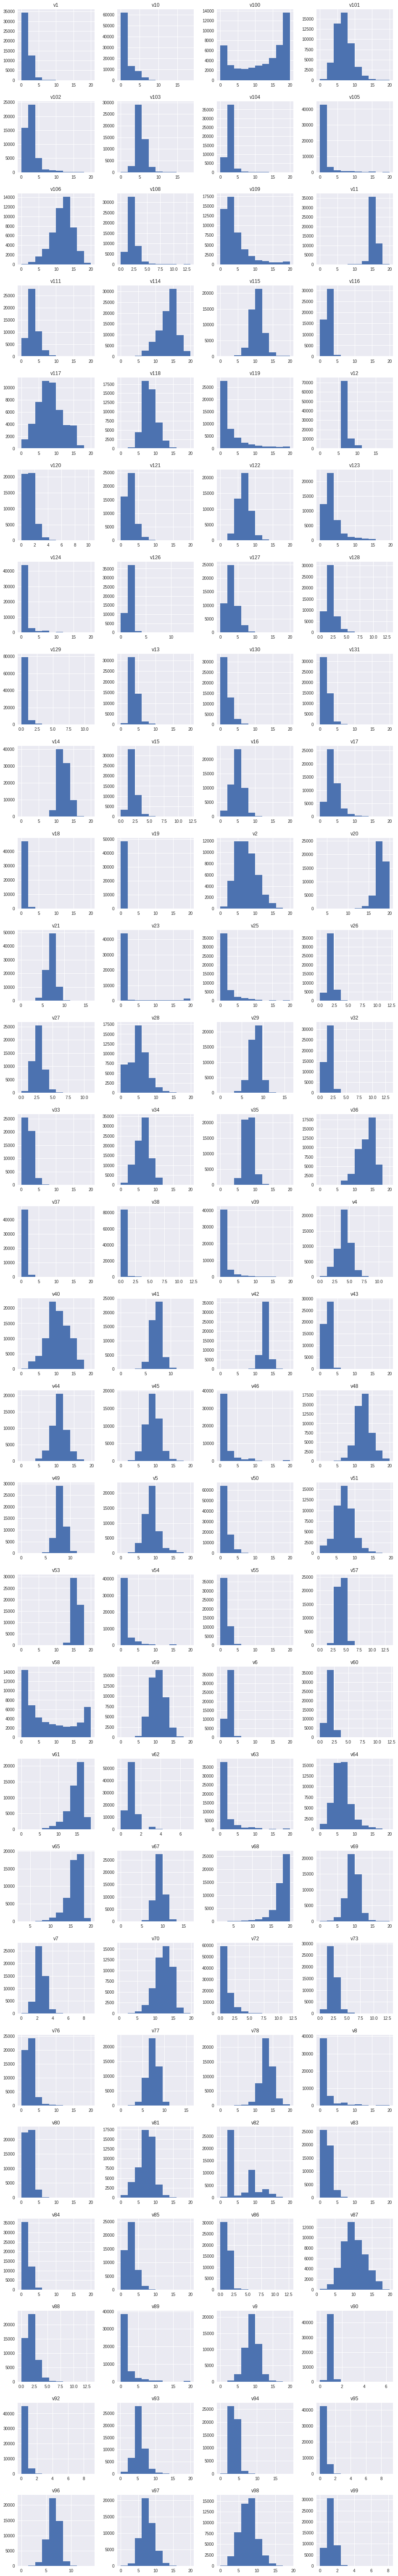

In [24]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

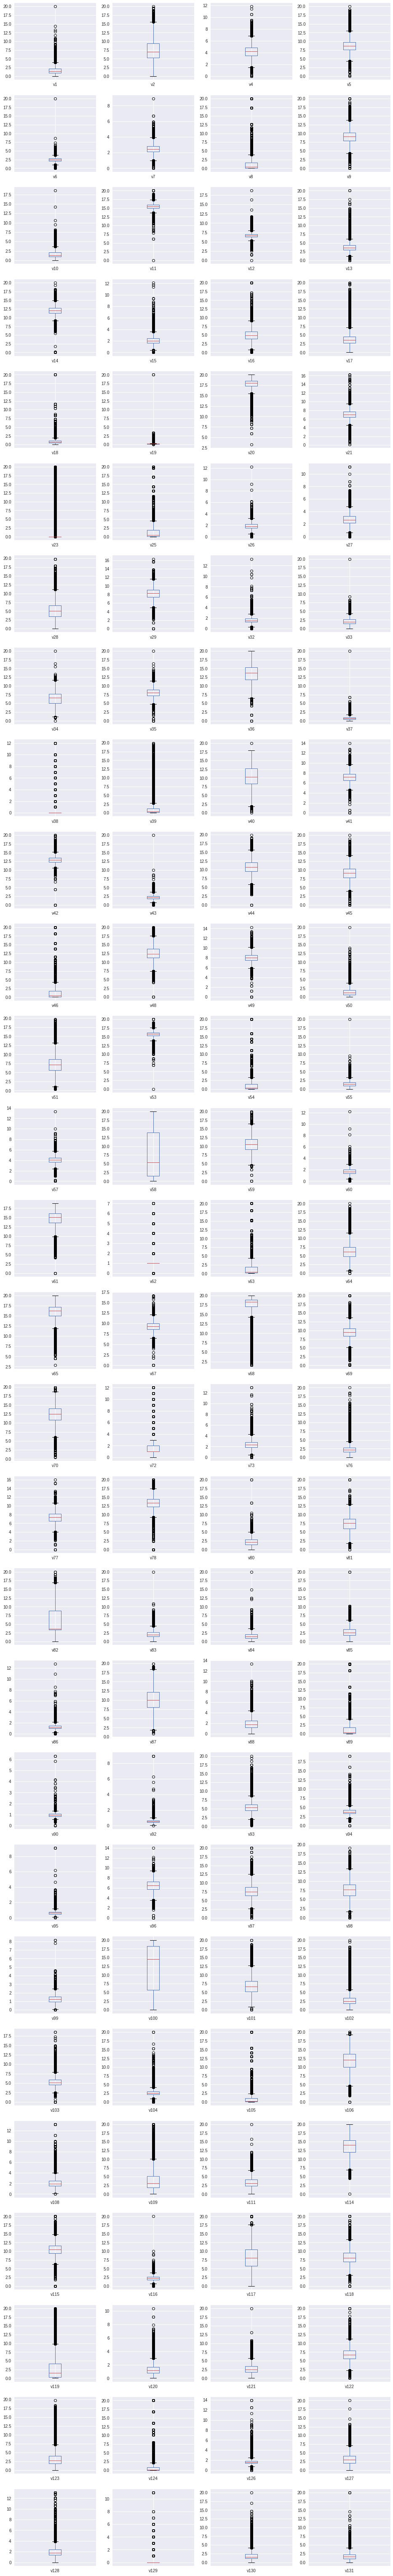

In [25]:
# Box and Whisker plot for each attribute
X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

In [26]:
# Correlation matrix
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111)
# correlations = X_train_df.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [27]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Prepare and Clean Data

In [28]:
if notifyStatus: status_notify("Task 3 - Prepare and Clean Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Build Data-Prep Pipeline

In [29]:
# Dropping columns with very low or no predictive power
X_train_df.drop(columns=['v22'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
# Compose pipeline for the numerical and categorical features
numeric_columns = X_train_df.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])
categorical_columns = X_train_df.select_dtypes(include=['object','bool']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the dataframe:", X_train_df.shape[1])

Number of numerical columns: 112
Number of categorical columns: 18
Total number of columns in the dataframe: 130


In [31]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training datasets for final inspection
X_train = preprocessor.fit_transform(X_train_df)
y_train = y_train_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (85740, 483) y_train.shape: (85740,)


In [32]:
if notifyStatus: status_notify("Task 3 - Prepare and Clean Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [33]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [34]:
# Set up Algorithms Spot-Checking Array
startTimeTraining = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')))

In [35]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeTraining))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: -0.470627 (0.001168)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)
Model training time: 0:00:10.673676 

Average metrics (neg_log_loss) from all models: -0.4706273314828417
Total training time for all models: 0:00:10.688549


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.7s finished


### 4.b) Spot-checking baseline algorithms

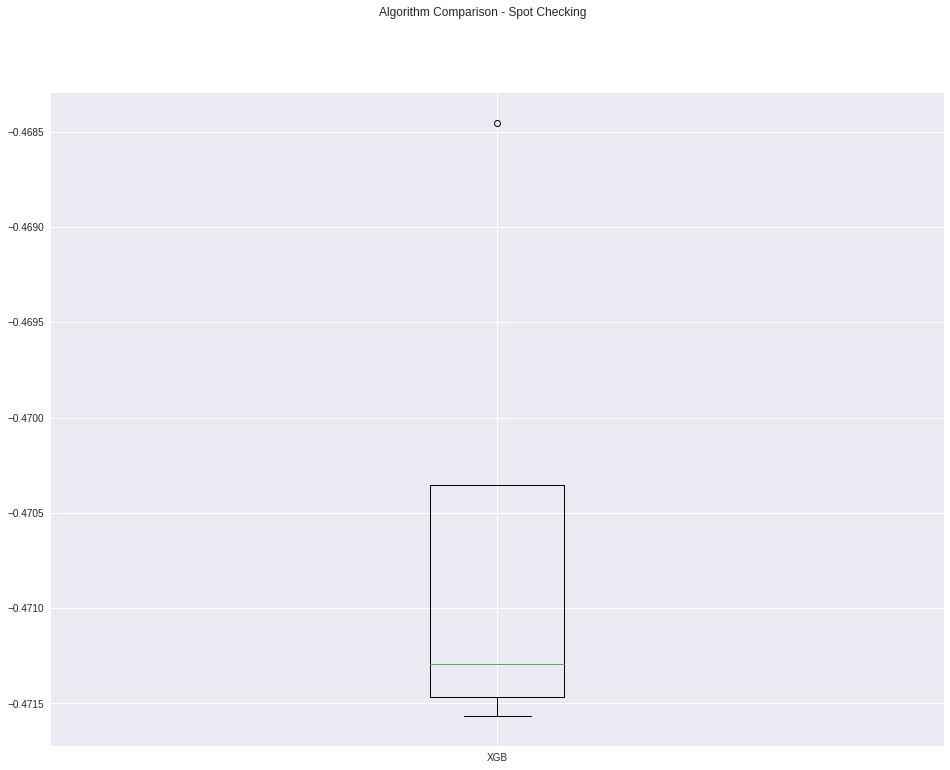

In [36]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [37]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [38]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [39]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [40]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm tuning iteration #1 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100,1001,100), max_depth=np.array([3,6,9]), min_child_weight=np.array([1,2,3]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm tuning iteration #1 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed: 55.3min finished


Best: -0.465372 using {'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 200}
-0.470627 (0.001168) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
-0.468004 (0.001456) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
-0.467121 (0.001493) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
-0.466813 (0.001696) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
-0.466629 (0.001596) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
-0.466647 (0.001641) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 600}
-0.466735 (0.001813) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 700}
-0.466849 (0.001798) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 800}
-0.466990 (0.001950) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 900}
-0.467104 (0.001887) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000}
-0.470584 (0.001262) with: {'max_dep

In [41]:
# Tuning XGBoost subsample and colsample_bytree parameters
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm tuning iteration #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(n_estimators=200, max_depth=6, min_child_weight=2, random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid1 = dict(subsample=np.array([0.5,0.75,1.0]), colsample_bytree=np.array([0.4,0.6,0.8,1.0]), learning_rate=np.array([0.01,0.03,0.05,0.1]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm tuning iteration #2 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 12.3min finished


Best: -0.465090 using {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'subsample': 1.0}
-0.489045 (0.000624) with: {'colsample_bytree': 0.4, 'learning_rate': 0.01, 'subsample': 0.5}
-0.488342 (0.000686) with: {'colsample_bytree': 0.4, 'learning_rate': 0.01, 'subsample': 0.75}
-0.488104 (0.000755) with: {'colsample_bytree': 0.4, 'learning_rate': 0.01, 'subsample': 1.0}
-0.468862 (0.001443) with: {'colsample_bytree': 0.4, 'learning_rate': 0.03, 'subsample': 0.5}
-0.467840 (0.001367) with: {'colsample_bytree': 0.4, 'learning_rate': 0.03, 'subsample': 0.75}
-0.467023 (0.001572) with: {'colsample_bytree': 0.4, 'learning_rate': 0.03, 'subsample': 1.0}
-0.466874 (0.001536) with: {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'subsample': 0.5}
-0.465642 (0.001822) with: {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'subsample': 0.75}
-0.465172 (0.001707) with: {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'subsample': 1.0}
-0.468575 (0.002095) with: {'colsample_bytree': 0.4, 'learning

### 5.b) Compare Algorithms After Tuning

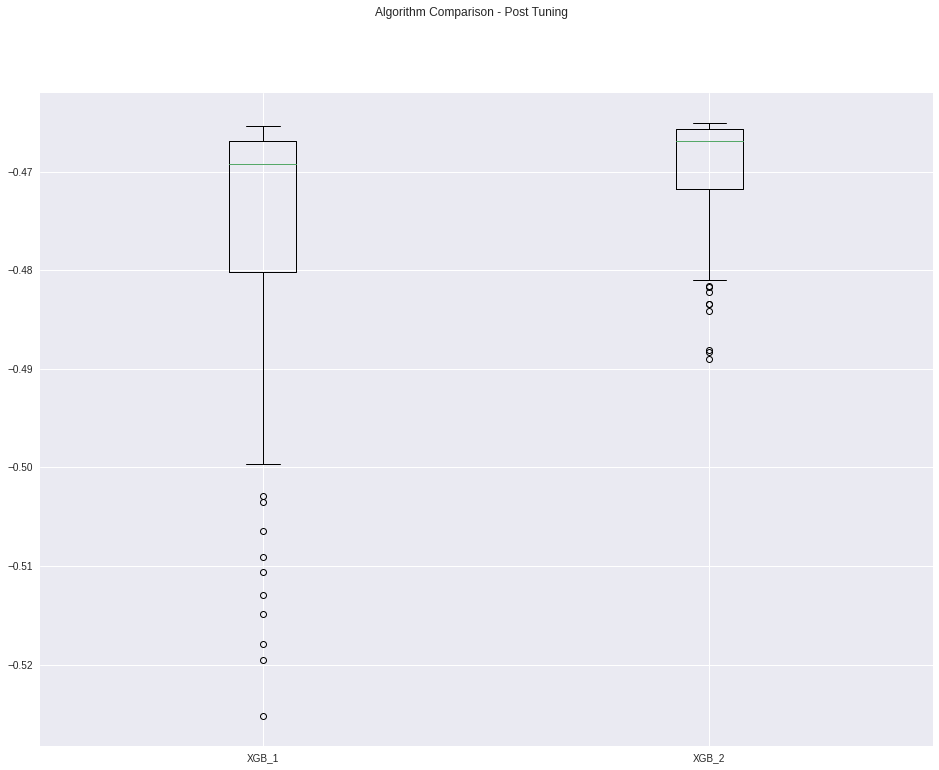

In [42]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [43]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [45]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the validation dataset

In [46]:
# Apply the same data preparation steps to the validation dataset
# Dropping columns with very low or no predictive power
X_validation_df.drop(columns=['v22'], inplace=True)

# Display the shapes of the training datasets for final inspection
X_validation = preprocessor.transform(X_validation_df)
y_validation = y_validation_df.ravel()
print("X_validation.shape: {} y_validation.shape: {}".format(X_validation.shape, y_validation.shape))

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


X_validation.shape: (28581, 483) y_validation.shape: (28581,)


In [47]:
validation_model = XGBClassifier(n_estimators=200, max_depth=6, min_child_weight=2, colsample_bytree=0.6, learning_rate=0.05, subsample=1.0,
                                 random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')
validation_model.fit(X_train, y_train)
predictions = validation_model.predict(X_validation)
probabilities = validation_model.predict_proba(X_validation)[:,1]
print('Accuracy Score:', accuracy_score(y_validation, predictions))
print('ROC/AUC Score:', roc_auc_score(y_validation, probabilities))
print('Logistic/Cross-Entropy Loss:', log_loss(y_validation, probabilities))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))
print(validation_model)

Accuracy Score: 0.7829327175396242
ROC/AUC Score: 0.7550315015621138
Logistic/Cross-Entropy Loss: 0.4674547471183182
[[ 1248  5577]
 [  627 21129]]
              precision    recall  f1-score   support

           0       0.67      0.18      0.29      6825
           1       0.79      0.97      0.87     21756

    accuracy                           0.78     28581
   macro avg       0.73      0.58      0.58     28581
weighted avg       0.76      0.78      0.73     28581

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, tree_method='gpu_hist', verbosity=1)


### 6.b) Create a standalone model using all available data

In [48]:
# Apply the same data preparation steps to the original training dataset

# Dropping columns with very low or no predictive power
X_original.drop(columns=['v22'], inplace=True)

# Display the shapes of the training datasets for final inspection
X_complete = preprocessor.fit_transform(X_original)
y_complete = y_original.ravel()
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
final_model = validation_model.fit(X_complete, y_complete)
print(final_model)

X_complete.shape: (114321, 486) y_complete.shape: (114321,)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1.0, tree_method='gpu_hist', verbosity=1)


### 6.c) Create Submission Files for Kaggle Evaluation

In [49]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-bnp-paribas-cardif-claims-management/test.csv'
X_kaggle_data = pd.read_csv(dataset_path, sep=',', index_col=False)

# Take a peek at the dataframe after import
X_kaggle_data.head(10)

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,...,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,0,1.375465e+00,11.361141,C,4.200778,6.577000,2.081784,1.784386,0.011094,9.523810,1.312911,16.851853,6.961173,3.107462,12.230137,1.773050,2.857142,3.493816,0.096826,0.225481,17.910227,7.437806,AFPB,9.558310e-07,E,0.069180,0.954152,4.386616,0.573017,6.988848,NaN,A,1.115242,2.081784,5.228503,8.178438,12.183225,8.333339e-01,0,2.842768e+00,...,0.658269,4.929298,2.992365,0.759955,5.947955,4.999999,10.013503,0.817844,19.708030,4.186787,1.873945,4.129022,1.701894,0.004535,11.688117,B,1.502480,2.121710,A,3.568773,U,NaN,12.246698,11.428572,1.276596,4.777902,5.833334,-9.974950e-07,1.459854,3.267328,7.619048,1.815241,1.112270e-07,AF,1.292368,3.903345,1.485925,0,2.333334,1.428572e+00
1,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.291029,NaN,6.618289,NaN,10.760796,NaN,NaN,NaN,NaN,NaN,NaN,5.895192,FOG,NaN,D,NaN,NaN,NaN,NaN,NaN,A,A,NaN,NaN,8.387431,NaN,NaN,NaN,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,NaN,NaN,B,NaN,E,NaN,16.284938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I,NaN,NaN,NaN,0,NaN,NaN
2,2,-4.903407e-07,8.201529,C,4.544371,6.550100,1.558442,2.467532,0.007164,7.142858,1.575492,15.142858,6.894249,1.899789,13.306189,1.302083,3.333334,3.177414,0.070676,0.172391,17.537549,8.253452,HXZ,-2.137218e-07,B,0.059620,2.857142,2.207792,0.327134,8.311689,C,A,0.974026,1.558442,7.958990,8.311689,12.195123,-5.249334e-07,0,6.707352e+00,...,0.552642,4.350983,3.163664,0.604966,6.233767,12.631578,10.214574,0.952380,19.799999,6.535555,0.762963,4.917534,1.981859,0.002794,11.747048,D,1.188768,2.088817,A,3.116883,Q,AJ,15.622710,13.333334,3.750001,4.740574,12.631580,4.910660e-08,0.600000,2.500001,5.714286,1.970928,1.412265e-02,AV,1.128724,5.844156,1.475892,0,1.263157,-6.380022e-07
3,7,2.661870e+00,3.041241,C,1.657216,9.773080,2.078337,1.430855,1.252157,7.959596,1.575493,14.424357,6.856236,5.086604,10.397026,2.803497,7.302904,1.121984,0.608524,0.476554,15.285588,5.539484,AGMU,5.863396e-07,E,1.779993,1.406875,1.350919,5.347444,6.474820,E,A,2.362111,3.852918,6.223849,6.634692,13.741929,2.011174e+00,0,8.248888e-07,...,0.775499,3.176199,5.071340,1.020527,4.980016,8.603352,5.743589,0.688783,0.116143,3.627655,NaN,7.486234,4.313037,1.048637,5.957084,B,2.690866,6.211596,A,3.932854,F,G,13.701587,6.804980,1.901235,12.446092,10.726256,1.824479e+01,2.322881,4.149590,4.404040,8.163614,1.100329e+00,B,1.988688,1.558753,2.448814,0,5.385474,1.493777e+00
4,10,1.252822e+00,11.283352,C,4.638388,8.520510,2.302484,3.510159,0.074263,7.612904,1.050328,15.589989,6.273627,2.500173,11.354501,1.353503,3.018868,4.974031,0.530779,0.148821,18.669490,6.741530,AWW,-2.725031e-07,E,0.158719,2.586531,3.261852,3.786615,8.860045,C,A,0.998871,1.196388,5.476858,7.742663,10.814992,3.858511e-01,0,4.897771e-01,...,0.389974,5.632135,3.885107,0.417548,6.941310,7.652733,8.589221,1.075998,19.227696,6.606787,1.493882,4.929004,1.906923,0.055134,14.666965,B,2.467017,5.312500,A,1.828443,A,I,13.395401,10.188679,3.031846,7.637177,8.038585,6.626723e-01,0.852197,1.676217,6.580644,1.325654,2.584588e-01,A,1.863796,2.666478,2.374275,0,0.681672,2.264151e+00
5,11,1.733601e+00,7.525109,C,3.263905,5.608608,2.356090,2.369477,0.065481,9.935483,0.656456,15.913043,6.344974,3.538897,11.268329,1.413043,6.434783,2.370286,0.457983,0.214822,17.433422,7.210579,PMR,-2.709114e-08,D,0.074814,1.570727,2.530121,3.192218,7.697456,C,A,1.546185,3.078982,2.915391,8.540829,12.623439,7.909610e-01,0,2.337280e-01,...,0.529553,4.549925,3.785681,0.645640,6.398928,6.440678,7.571328,1.055333,18.950617,5.467954,1.820259,5.440665,2.261760,0.027792,9.968654,D,1.472781,1.365132,A,4.337350,I,G,9.275629,9.391304,1.982608,3.747666,7.231637,2.073860e-01,1.574074,3.408000,5.032257,2.551374,-9.

In [50]:
# Set up the dataframe to capture predictions for Kaggle submission
y_submission_kaggle = pd.DataFrame(columns=['ID', 'PredictedProb'])
y_submission_kaggle['ID'] = X_kaggle_data['ID']
X_kaggle_data.drop(columns=['ID'], inplace=True)
y_submission_kaggle.head()

,ID,PredictedProb
0,0,NaN
1,1,NaN
2,2,NaN
3,7,NaN
4,10,NaN


In [51]:
# Apply the same data preparation steps to the test dataset

# Dropping columns with very low or no predictive power
X_kaggle_data.drop(columns=['v22'], inplace=True)

# Display the shapes of the training datasets for final inspection
X_test_kaggle = preprocessor.transform(X_kaggle_data)
print("X_test_kaggle.shape: {}".format(X_test_kaggle.shape))

X_test_kaggle.shape: (114393, 486)


In [52]:
probabilities_kaggle = final_model.predict_proba(X_test_kaggle)[:,1]
y_submission_kaggle['PredictedProb'] = probabilities_kaggle
print("y_submission_kaggle.shape: {}".format(y_submission_kaggle.shape))

y_submission_kaggle.shape: (114393, 2)


In [53]:
submission_file = y_submission_kaggle.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20200805-0117.csv


In [54]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [55]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 1:37:55.763819
